In [1]:
import os
if os.path.exists("preprocessed_data(try).pt"):
    os.remove("preprocessed_data(try).pt")


In [1]:
# ===============================
# 🚀 1. Imports & Setup
# ===============================
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.optim import AdamW   # ✅ fixed import
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time, random, os

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
import torch
import joblib

data = torch.load("/content/preprocessed_data (2).pt")
le = joblib.load("/content/label_encoder.pkl")
print("Loaded label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))


Loaded label mapping: {'Active to Passive': 0, 'Direct to Indirect': 1, 'Indirect to Direct': 2, 'Negative to Positive': 3, 'Passive to Active': 4, 'Positive to Negative': 5}


In [7]:
# ===============================
# 📂 2. Load Preprocessed Data (Fixed Version)
# ===============================
from torch.utils.data import TensorDataset, DataLoader
import transformers
import joblib
import torch

torch.serialization.add_safe_globals([transformers.tokenization_utils_base.BatchEncoding])

# ✅ Load preprocessed dataset
data = torch.load("/content/preprocessed_data (2).pt", weights_only=False)

# ✅ Load label encoder separately
le = joblib.load("/content/label_encoder.pkl")

print("Classes:", list(le.classes_))
num_labels = len(le.classes_)

# ✅ Create TensorDatasets with correct label dtype
train_dataset = TensorDataset(
    data['train_input']['input_ids'],
    data['train_input']['attention_mask'],
    data['train_labels'].long()
)
val_dataset = TensorDataset(
    data['val_input']['input_ids'],
    data['val_input']['attention_mask'],
    data['val_labels'].long()
)
test_dataset = TensorDataset(
    data['test_input']['input_ids'],
    data['test_input']['attention_mask'],
    data['test_labels'].long()
)

# ✅ DataLoaders
train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dl   = DataLoader(val_dataset, batch_size=16)
test_dl  = DataLoader(test_dataset, batch_size=16)

print("✅ Data loaded and ready for training.")



Classes: ['Active to Passive', 'Direct to Indirect', 'Indirect to Direct', 'Negative to Positive', 'Passive to Active', 'Positive to Negative']
✅ Data loaded and ready for training.


In [8]:
# ===============================
# 3. Define Model
# ===============================
MODEL_NAME = "distilroberta-base"
  # or try "bert-base-uncased","distilobertabase"

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# ===============================
# ⚙️ 4. Training Setup
# ===============================
EPOCHS = 9
LR = 2e-5
batch_size=16

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
total_steps = len(train_dl) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.06 * total_steps),
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()


In [20]:
# ===============================
# 🏋️‍♂️ 5. Training Function
# ===============================
def train_one_epoch(model, dataloader):
    model.train()
    total_loss, correct = 0, 0
    for batch in dataloader:
        b_input_ids, b_mask, b_labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_mask, labels=b_labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        correct += (logits.argmax(dim=1) == b_labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)



In [21]:
# ===============================
# 🧪 6. Evaluation Function
# ===============================
def evaluate(model, dataloader):
    model.eval()
    total_loss, correct = 0, 0
    preds, labels_all = [], []
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_mask, b_labels = [x.to(device) for x in batch]
            outputs = model(input_ids=b_input_ids, attention_mask=b_mask, labels=b_labels)
            loss, logits = outputs.loss, outputs.logits
            total_loss += loss.item()
            preds += logits.argmax(dim=1).cpu().tolist()
            labels_all += b_labels.cpu().tolist()
            correct += (logits.argmax(dim=1) == b_labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset), preds, labels_all


In [22]:
# ===============================
# 🚀 7. Training Loop
# ===============================
best_val_acc = 0
for epoch in range(EPOCHS):
    start = time.time()
    train_loss, train_acc = train_one_epoch(model, train_dl)
    val_loss, val_acc, _, _ = evaluate(model, val_dl)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("Time:", round(time.time() - start, 2), "sec")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Best model saved.")


Epoch 1/9
Train Loss: 0.4810, Train Acc: 0.7937
Val Loss: 0.9593, Val Acc: 0.5873
Time: 6.8 sec
✅ Best model saved.
Epoch 2/9
Train Loss: 0.4225, Train Acc: 0.8060
Val Loss: 0.9664, Val Acc: 0.5767
Time: 6.93 sec
Epoch 3/9
Train Loss: 0.3805, Train Acc: 0.8377
Val Loss: 1.1713, Val Acc: 0.5820
Time: 6.99 sec
Epoch 4/9
Train Loss: 0.3243, Train Acc: 0.8765
Val Loss: 1.2308, Val Acc: 0.5661
Time: 8.28 sec
Epoch 5/9
Train Loss: 0.3090, Train Acc: 0.8818
Val Loss: 1.2692, Val Acc: 0.5820
Time: 7.02 sec
Epoch 6/9
Train Loss: 0.2563, Train Acc: 0.9065
Val Loss: 1.3176, Val Acc: 0.5926
Time: 6.9 sec
✅ Best model saved.
Epoch 7/9
Train Loss: 0.2177, Train Acc: 0.9347
Val Loss: 1.4389, Val Acc: 0.5714
Time: 6.77 sec
Epoch 8/9
Train Loss: 0.1889, Train Acc: 0.9312
Val Loss: 1.4844, Val Acc: 0.5820
Time: 6.7 sec
Epoch 9/9
Train Loss: 0.1577, Train Acc: 0.9506
Val Loss: 1.5158, Val Acc: 0.5767
Time: 6.73 sec


In [23]:
# ===============================
# 🧪 8. Test Evaluation
# ===============================
model.load_state_dict(torch.load("best_model.pt"))
test_loss, test_acc, preds, labels_all = evaluate(model, test_dl)

print(f"\n🎯 Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(labels_all, preds, target_names=le.classes_))



🎯 Test Loss: 1.3068, Test Accuracy: 0.6032

Classification Report:
                      precision    recall  f1-score   support

   Active to Passive       0.56      0.53      0.55        34
  Direct to Indirect       0.57      0.71      0.63        34
  Indirect to Direct       0.62      0.47      0.53        34
Negative to Positive       0.68      0.65      0.67        26
   Passive to Active       0.56      0.59      0.57        34
Positive to Negative       0.68      0.70      0.69        27

            accuracy                           0.60       189
           macro avg       0.61      0.61      0.61       189
        weighted avg       0.61      0.60      0.60       189



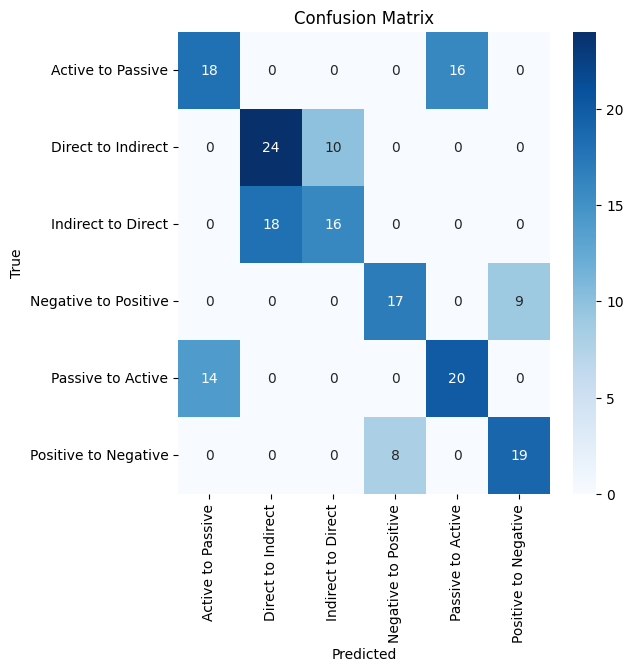

In [24]:
# ===============================
# 🔍 9. Confusion Matrix
# ===============================
cm = confusion_matrix(labels_all, preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [27]:
# ===============================
# 💾 10. Save Full Model
# ===============================
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model.save_pretrained("transformation_classifier")
tokenizer.save_pretrained("transformation_classifier")
print("✅ Model + tokenizer saved in 'transformation_classifier/' folder")

✅ Model + tokenizer saved in 'transformation_classifier/' folder


In [28]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r transformation_classifier /content/drive/MyDrive/
print("✅ Model folder copied to Google Drive!")


Mounted at /content/drive
✅ Model folder copied to Google Drive!
